In [1]:
from tqdm import tqdm
import numpy as np
import torch
import collections
import random
from EMS_DDPG import *
import copy

import sys
sys.path.append('DDPG_code')

c:\Users\Can\anaconda3\envs\City\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


import numpy as np
import argparse
from DDPG_code.DDPG import DDPG
from DDPG_code.utils import create_directory, plot_learning_curve, scale_action

import local_energy_market_environment as leme

random.seed(1)
torch.manual_seed(1)
env = leme.LEME()

max_episodes = 1000
checkpoint_dir = './checkpoints/DDPG/'
figure_file = './output_images/reward.png'

In [3]:
# 让noise 衰减
decay_factor = 0.99 
min_sigma = 0.01

In [4]:


agent = DDPG(alpha=0.0003, beta=0.0003, state_dim=19,
                action_dim=4, actor_fc1_dim=256, actor_fc2_dim=64,
                critic_fc1_dim=256, critic_fc2_dim=64, ckpt_dir=checkpoint_dir,
                batch_size=256)
create_directory(checkpoint_dir,
                    sub_paths=['Actor', 'Target_actor', 'Critic', 'Target_critic'])

reward_history = []

L_cost =[]
L_penalty_commuting=[]
L_penalty_thermal =[]

avg_reward_history = []
for episode in range(max_episodes):
    done = False
    total_reward = 0

    episode_cost = 0
    episode_penalty_commuting = 0
    episode_penalty_thermal = 0



    observation = env.reset()
    while not done:
        observation = observation[0]
        action = agent.choose_action(observation, train=True)
        action_ = scale_action(action.copy(), 1, -1)

        action_ = [action_]

        observation_, reward, done, cost,penalty_commuting,penalty_thermal = env.step(action_)

        agent.remember(observation, action, reward[0], observation_[0], done)



        agent.action_noise = max(agent.action_noise * decay_factor ** episode, min_sigma)
        agent.learn()
        total_reward += reward[0]


        episode_cost += cost[0]
        episode_penalty_commuting += penalty_commuting[0]
        episode_penalty_thermal += penalty_thermal[0]


        observation = observation_

    reward_history.append(total_reward)

    L_cost.append(episode_cost)
    L_penalty_commuting.append(episode_penalty_commuting)
    L_penalty_thermal.append(episode_penalty_thermal)

    avg_reward = np.mean(reward_history[-100:])
    avg_reward_history.append(avg_reward)
    print('Ep: {} Reward: {:.1f} AvgReward: {:.1f}'.format(episode+1, total_reward, avg_reward))

    if (episode + 1) % 200 == 0:
        agent.save_models(episode+1)

        



Path: ./checkpoints/DDPG/Actor is already existence
Path: ./checkpoints/DDPG/Target_actor is already existence
Path: ./checkpoints/DDPG/Critic is already existence
Path: ./checkpoints/DDPG/Target_critic is already existence
Ep: 1 Reward: -68.6 AvgReward: -68.6
Ep: 2 Reward: -84.6 AvgReward: -76.6
Ep: 3 Reward: -77.6 AvgReward: -76.9
Ep: 4 Reward: -97.8 AvgReward: -82.2
Ep: 5 Reward: -68.6 AvgReward: -79.4
Ep: 6 Reward: -69.7 AvgReward: -77.8
Ep: 7 Reward: -64.8 AvgReward: -76.0
Ep: 8 Reward: -97.6 AvgReward: -78.7
Ep: 9 Reward: -72.3 AvgReward: -78.0
Ep: 10 Reward: -67.8 AvgReward: -76.9
Ep: 11 Reward: -82.8 AvgReward: -77.5
Ep: 12 Reward: -49.9 AvgReward: -75.2
Ep: 13 Reward: -95.9 AvgReward: -76.8
Ep: 14 Reward: -88.4 AvgReward: -77.6
Ep: 15 Reward: -90.7 AvgReward: -78.5
Ep: 16 Reward: -80.4 AvgReward: -78.6
Ep: 17 Reward: -105.4 AvgReward: -80.2
Ep: 18 Reward: -103.5 AvgReward: -81.5
Ep: 19 Reward: -110.5 AvgReward: -83.0
Ep: 20 Reward: -102.9 AvgReward: -84.0
Ep: 21 Reward: -110.0

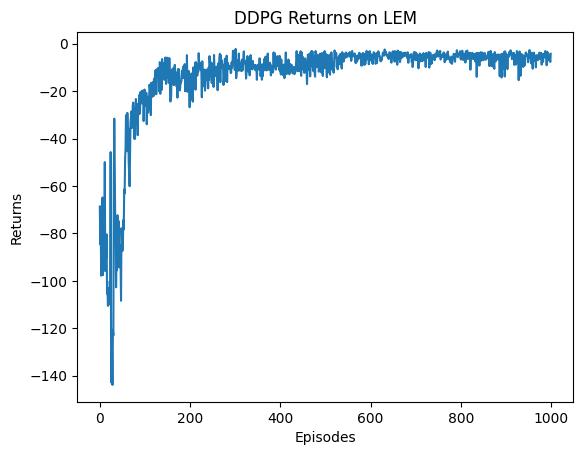

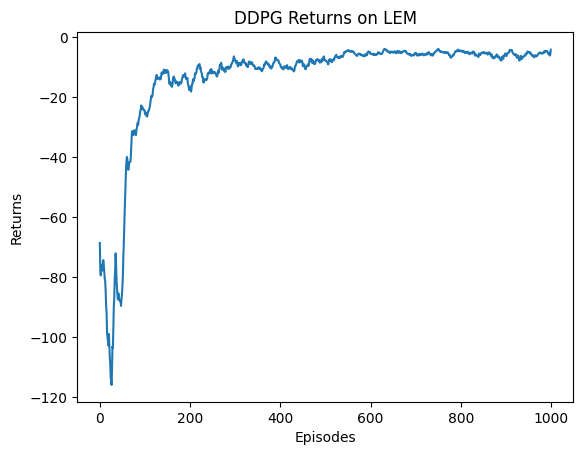

In [9]:
import matplotlib.pyplot as plt

import rl_utils
episodes_list = list(range(len(reward_history)))
plt.plot(episodes_list, reward_history)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG Returns on {}'.format('LEM'))
plt.show()

mv_return = rl_utils.moving_average(reward_history, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG Returns on {}'.format('LEM'))
plt.show()

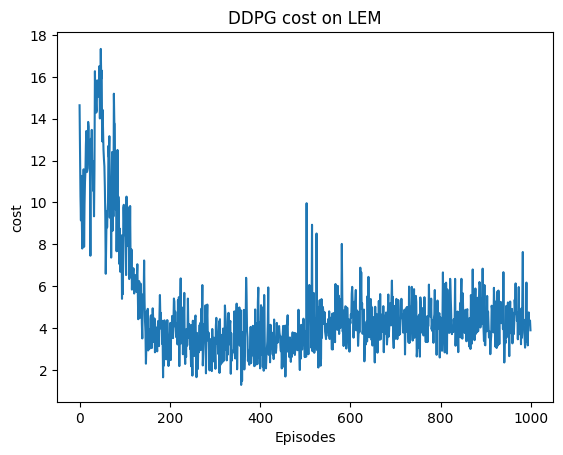

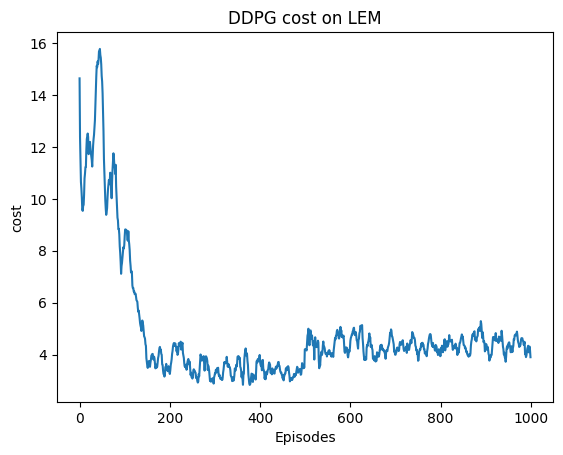

In [10]:
episodes_list = list(range(len(L_cost)))
plt.plot(episodes_list, L_cost)
plt.xlabel('Episodes')
plt.ylabel('cost')
plt.title('DDPG cost on {}'.format('LEM'))
plt.show()

mv_return = rl_utils.moving_average(L_cost, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('cost')
plt.title('DDPG cost on {}'.format('LEM'))
plt.show()

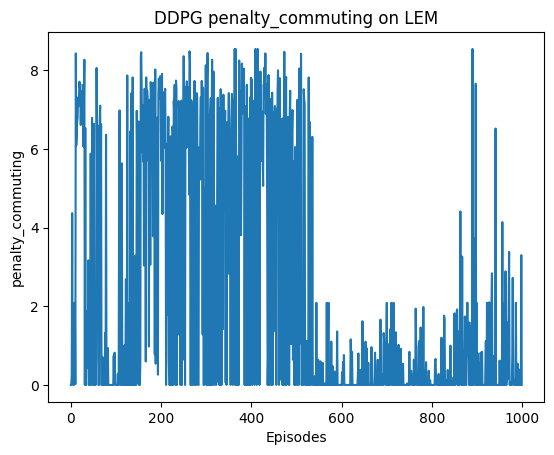

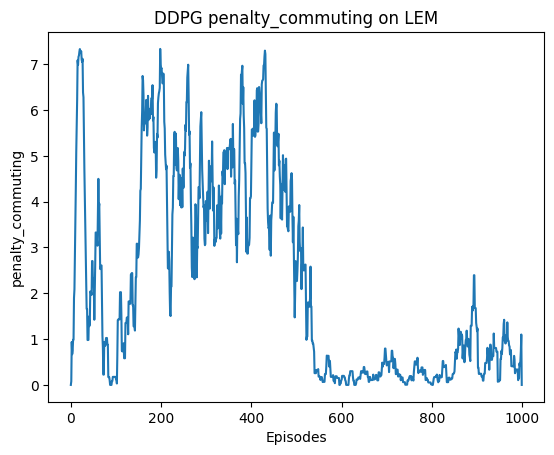

In [7]:
episodes_list = list(range(len(L_penalty_commuting)))
plt.plot(episodes_list, L_penalty_commuting)
plt.xlabel('Episodes')
plt.ylabel('penalty_commuting')
plt.title('DDPG penalty_commuting on {}'.format('LEM'))
plt.show()

mv_return = rl_utils.moving_average(L_penalty_commuting, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('penalty_commuting')
plt.title('DDPG penalty_commuting on {}'.format('LEM'))
plt.show()

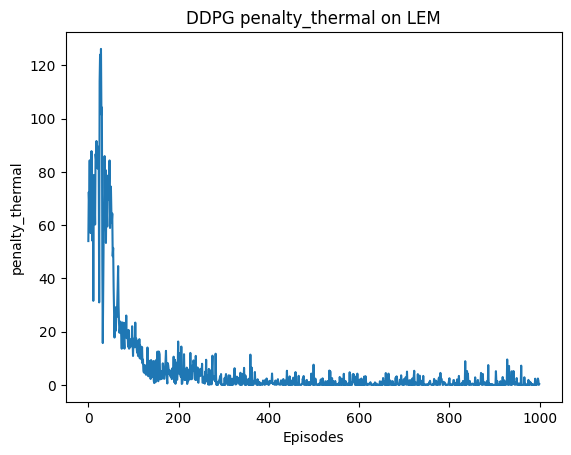

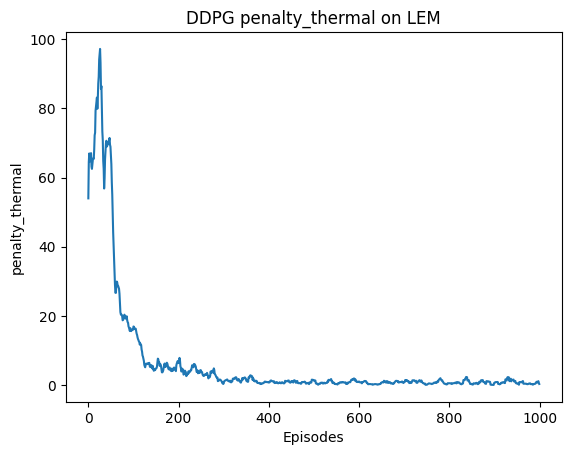

In [8]:
episodes_list = list(range(len(L_penalty_thermal)))
plt.plot(episodes_list, L_penalty_thermal)
plt.xlabel('Episodes')
plt.ylabel('penalty_thermal')
plt.title('DDPG penalty_thermal on {}'.format('LEM'))
plt.show()

mv_return = rl_utils.moving_average(L_penalty_thermal, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('penalty_thermal')
plt.title('DDPG penalty_thermal on {}'.format('LEM'))
plt.show()